High Value Customers Identification

# Project Solution Planning

## Inputs

1. Problema de Negócio
    - Taxa de churn aumentou nos últimos meses
    - Rankear os clientes com maiores probabilidades de entrar em churn

2. Conjunto de dados
    - Atributos que descrevem os clientes de um determinado banco: ChrunDataset Kaggle

## Output

1. Indicação das pessoas que irão entrar em churn
    - Coluna em tabela com rankeado das pessoas com propensão de entrar em churn
    - Modelo em produção
    
2. Relatório com performance do modelo e respostas das perguntas:
     - Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?
     - Qual a Performance do modelo em classificar os clientes como churns?
     - Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?
     - Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  R$10.000,00
    

## Tasks

1. Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?
    - Calcular taxa atual, somatório da coluna target divido pelo número total de clientes da base
    
2. Qual a Performance do modelo em classificar os clientes como churns?
    - Calculo da performance do modelo
    - Verificar métricas de performance learning to rank
    
3. Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?
    - Curva lift para comparação do modelo com o status quo da empresa e apresentação do resultado
    - Calcular diferença em reais do modelo
    - Calcular ROI
    - Comparativo entre ROIs

4. Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  R$10.000,00
    - Classificar quais clientes trarão mais retorno para empresa com o incentivo.
    

# Imports

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import inflection

import missingno as msno


from IPython.core.display    import HTML
from IPython.display         import Image

In [2]:
os.getcwd()

'/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/notebooks'

## Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
# def cramer_v( x, y ):
#     cm = pd.crosstab( x, y ).values # Confusion Matrix
#     n = cm.sum()
#     r, k = cm.shape
    
#     chi2 = ss.chi2_contingency( cm )[0]
#     chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
#     kcorr = k - (k-1)**2/(n-1)
#     rcorr = r - (r-1)**2/(n-1)
    
#     return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# def mean_absolute_percentage_error( y, yhat ):
#     return np.mean( np.abs( ( y-yhat ) / y ))

# def mean_percentage_error( y, yhat ):
#     return np.mean( ( y - yhat ) / y )

# def ml_error ( model_name, y, yhat):
#     mae = mean_absolute_error( y,yhat )
#     mape = mean_absolute_percentage_error( y,yhat )
#     rmse = np.sqrt(mean_squared_error( y,yhat ))
    
#     return pd.DataFrame( {'Model Name': model_name,
#                           'MAE': mae,
#                           'MAPE': mape,
#                           'RMSE': rmse}, index=[0])

# def cross_validation( x_training, kfold, model_name, model, verbose=False ):
#     mae_list = []
#     mape_list = []
#     rmse_list = []
    
#     for k in reversed( range( 1, kfold+1 ) ):
#         if verbose:
#             print( '\nKFold Number: {}'.format( k ) )
#         # start and end date for validation 
#         start_date_validation = x_training['date'].max() - datetime.timedelta( days=k*6*7)
#         end_date_validation = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

#         # filtering dataset
#         training = x_training[x_training['date'] < start_date_validation]
#         validation = x_training[(x_training['date'] >= start_date_validation) & (x_training['date'] <= end_date_validation)]

#         # training and validation dataset
#         # training
#         xtraining = training.drop( ['date', 'sales'], axis=1 ) 
#         ytraining = training['sales']

#         # validation
#         xvalidation = validation.drop( ['date', 'sales'], axis=1 )
#         yvalidation = validation['sales']

#         # model
#         m = model.fit( xtraining, ytraining )

#         # prediction
#         yhat = m.predict( xvalidation )

#         # performance
#         m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

#         # store performance of each kfold iteration
#         mae_list.append(  m_result['MAE'] )
#         mape_list.append( m_result['MAPE'] )
#         rmse_list.append( m_result['RMSE'] )

#     return pd.DataFrame( {'Model Name': model_name,
#                           'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
#                           'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
#                           'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Loading Dataset

 - **Source**: https://www.kaggle.com/mervetorkan/churndataset

In [5]:
df_churn_raw = pd.read_csv('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/data/raw/churn.csv', low_memory = False)

In [6]:
df_churn_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Feature Description**:

- **RowNumber**: The number of the columns.
- **CustomerID**: Unique client identifier.
- **Surname**: Client's surname.
- **CreditScore**: Client's credit card score for the financial market A pontuação de Crédito do cliente para o mercado de consumo.
- **Geography**: The country where the client lives.
- **Gender**: Client's gender.
- **Age**: Client's age.
- **Tenure**: The number of years the client remained activate in the bank.
- **Balance**: The monetary amount the client has in their current account.
- **NumOfProducts**: The number of products purchased by the client.
- **HasCrCard**: Point if the client has a credit card.
- **IsActiveMember**: Tell if the client is an active member of the bank (within the last 12 months).
- **EstimateSalary**: Client's annual salary estimate.
- **Exited**: Indicates if the client is a churn (tagert variable).

# DATA DISCRIPTION

In [96]:
# copy dataset
df0 = df_churn_raw.copy()

## Rename Columns

In [97]:
cols_old = list(df0)
snakecase = lambda x: inflection.underscore(x)
col_news = list(map(snakecase, cols_old))

# Rename columns
df0.columns = col_news
list(df0)

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited']

In [98]:
df0.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Feature Description**:

- **RowNumber**: The number of the columns.
- **CustomerID**: Unique client identifier.
- **Surname**: Client's surname.
- **CreditScore**: Client's credit card score for the financial market A pontuação de Crédito do cliente para o mercado de consumo.
- **Geography**: The country where the client lives.
- **Gender**: Client's gender.
- **Age**: Client's age.
- **Tenure**: The number of years the client remained activate in the bank.
- **Balance**: The monetary amount the client has in their current account.
- **NumOfProducts**: The number of products purchased by the client.
- **HasCrCard**: Point if the client has a credit card.
- **IsActiveMember**: Tell if the client is an active member of the bank (within the last 12 months).
- **EstimateSalary**: Client's annual salary estimate.
- **Exited**: Indicates if the client is a churn (tagert variable).

## Data Dimension and Type

In [99]:
print('Number of rows: {}'.format(df0.shape[0]))
print('Number of columns: {}'.format(df0.shape[1]))

Number of rows: 10000
Number of columns: 14


In [100]:
# check columns datatypes
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Check for duplicates

In [101]:
# duplicates 

df0.duplicated(subset='customer_id').sum()

0

## Check NA Values

In [102]:
missing_count = df0.isnull().sum()
value_count = df0.isnull().count()

missing_percentage = round(missing_count/value_count*100, 2)
missing_df = pd.DataFrame({'missing value count': missing_count, 'percentage (%)': missing_percentage })
missing_df

,missing value count,percentage (%)
row_number,0,0.0
customer_id,0,0.0
surname,0,0.0
credit_score,0,0.0
geography,0,0.0
gender,0,0.0
age,0,0.0
tenure,0,0.0
balance,0,0.0
num_of_products,0,0.0


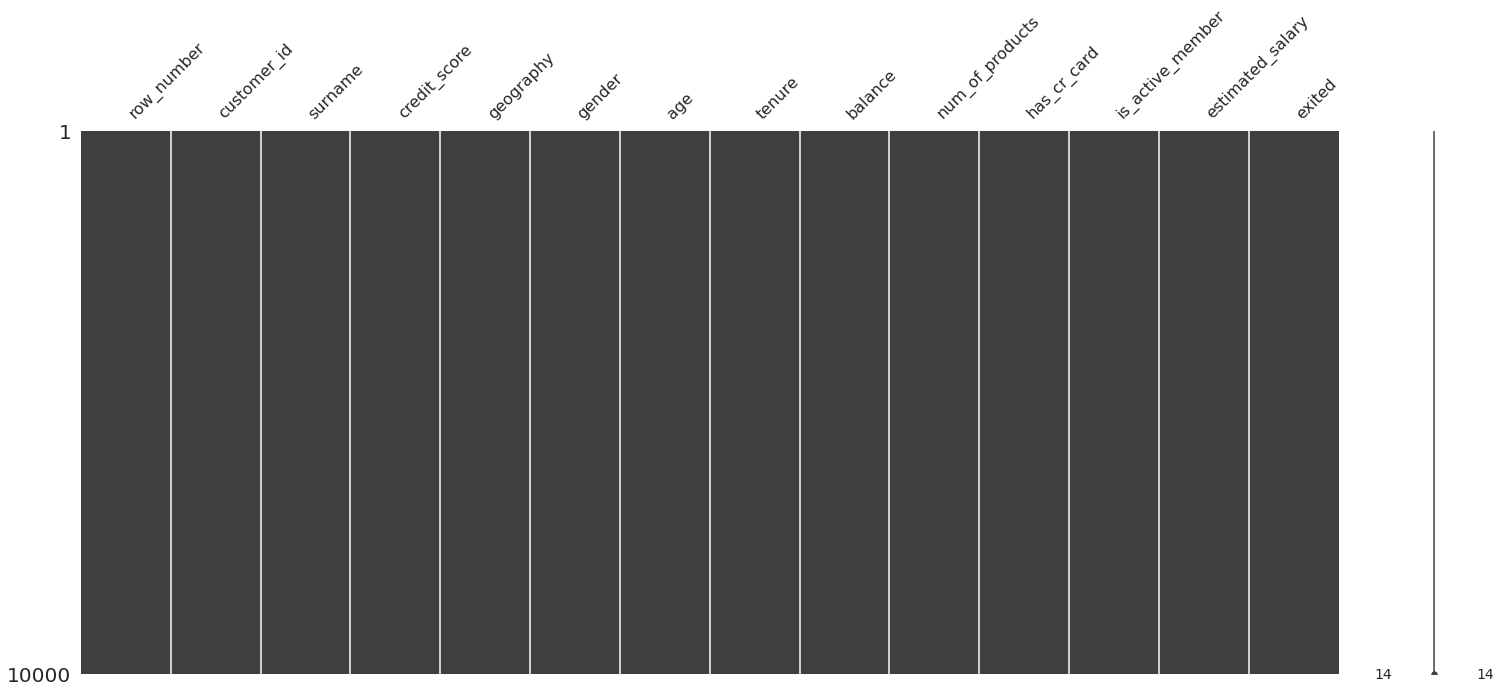

In [103]:
# check no missing values to confirm
msno.matrix(df0);

## Descriptive Statistics

In [104]:
df0.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [105]:
list(df0)

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited']

In [106]:
# transforming categorical 1 or 0 values into 'yes' or 'no
col_transform = ['has_cr_card', 'is_active_member']

for col in col_transform:
    df0[col] = df0[col].astype('str') 

for col in col_transform:
    df0[col] = df0[col].apply(lambda x: 'yes' if x=='1' else 'no')


In [107]:
# separate numerical and categorical attributes

num_att = df0.select_dtypes(include = 'number')
cat_att = df0.select_dtypes(include = 'object')

### Numerical Attributes

In [108]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_att.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_att.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_att.apply( np.std )).T
d2 = pd.DataFrame(num_att.apply( min )).T
d3 = pd.DataFrame(num_att.apply( max )).T
d4 = pd.DataFrame(num_att.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_att.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_att.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,row_number,1.00,10000.00,9999.00,5.000500e+03,5.000500e+03,2886.751332,0.000000,-1.200000
1,customer_id,15565701.00,15815690.00,249989.00,1.569094e+07,1.569074e+07,71932.589224,0.001149,-1.196113
2,credit_score,350.00,850.00,500.00,6.505288e+02,6.520000e+02,96.648466,-0.071607,-0.425726
3,age,18.00,92.00,74.00,3.892180e+01,3.700000e+01,10.487282,1.011320,1.395347
4,tenure,0.00,10.00,10.00,5.012800e+00,5.000000e+00,2.892030,0.010991,-1.165225
5,balance,0.00,250898.09,250898.09,7.648589e+04,9.719854e+04,62394.285254,-0.141109,-1.489412
6,num_of_products,1.00,4.00,3.00,1.530200e+00,1.000000e+00,0.581625,0.745568,0.582981
7,estimated_salary,11.58,199992.48,199980.90,1.000902e+05,1.001939e+05,57507.617221,0.002085,-1.181518
8,exited,0.00,1.00,1.00,2.037000e-01,0.000000e+00,0.402748,1.471611,0.165671


In [109]:
num_att.apply( lambda x: x.unique().shape[0])

row_number          10000
customer_id         10000
credit_score          460
age                    70
tenure                 11
balance              6382
num_of_products         4
estimated_salary     9999
exited                  2
dtype: int64

### Categorical Attributes

In [110]:
# check unique values of categorical features
cat_att.apply( lambda x: x.unique().shape[0])

surname             2932
geography              3
gender                 2
has_cr_card            2
is_active_member       2
dtype: int64

In [ ]:
# plot boxplots of categorical features against target variable

### Zero values distribution

 Sometimes the data isn't missing (NaNs), but it can be in a form of an oddly high number of zero values 
 
 **Conclusion**: The 'Balance' columns have a great number of zeros, but it doesn't mean they are missing values (NaNs). Nevertheless, the Data Science team should get in contact with the business team to check if this number is correct

In [115]:
# create DataFrame with zero and non zero values
num_zero = num_att.copy()
num_col = num_zero.columns

for col in num_col :
    num_zero[col] = num_zero[col].apply(lambda x: 'zero' if x==0 else 'not zero')

In [116]:
# check which columns have zero values 

num_zero.apply( lambda x: x.unique().shape[0])

row_number          1
customer_id         1
credit_score        1
age                 1
tenure              2
balance             2
num_of_products     1
estimated_salary    1
exited              2
dtype: int64

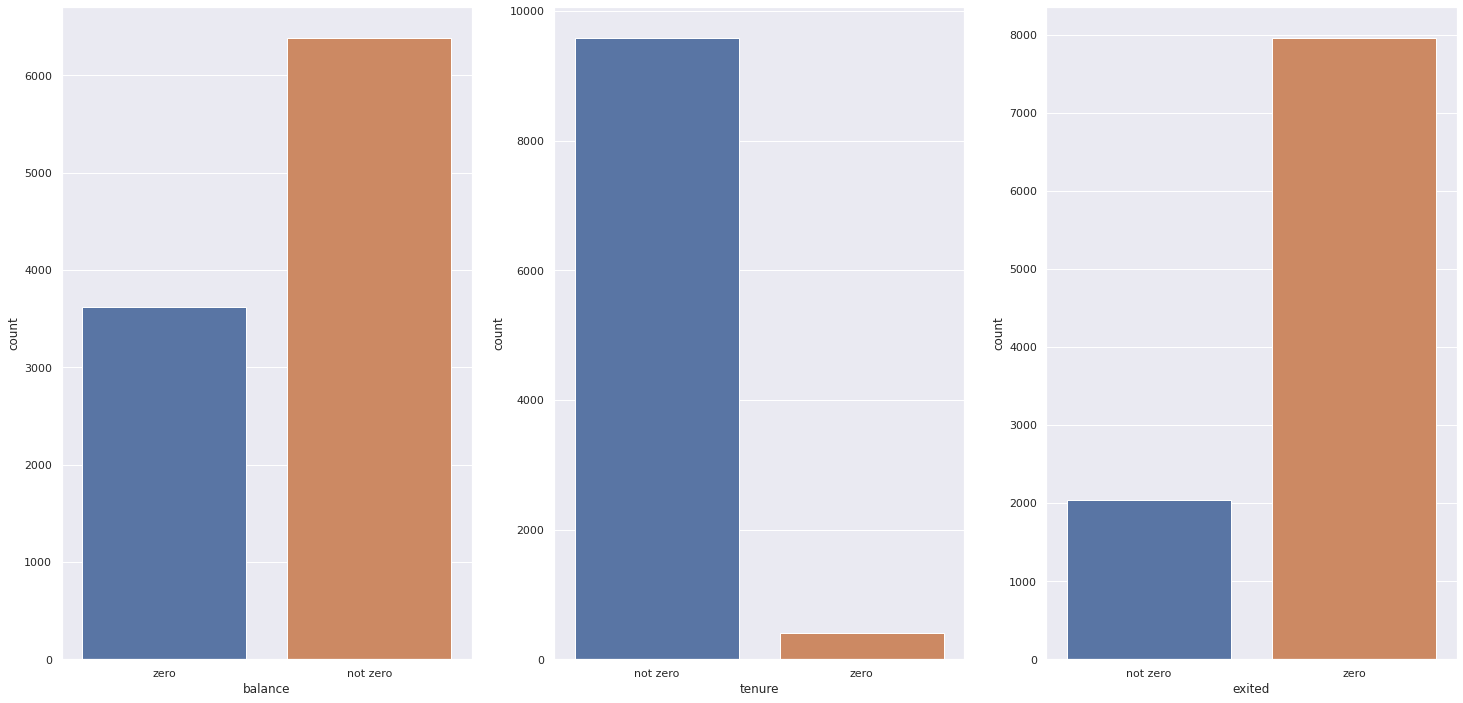

In [120]:
#Plot zero values proportion 
plt.subplot(1,3,1)
sns.countplot(x = 'balance', data = num_zero) 

plt.subplot(1,3,2)
sns.countplot(x = 'tenure', data = num_zero) 

plt.subplot(1,3,3)
sns.countplot(x = 'exited', data = num_zero);

# FEATURE ENGINEERING

## Hypothesis Mindmap

## Creating Hypothesis

## Final Hypothesis List

## Feature Engineering

# VARIABLE FILTERING

## Line Filtering

## Columns Selection

# EXPLORATORY DATA ANALYSIS (EDA)

## Univariate Analysis

### Response Variable

### Numerical Variable

### Categorical Variable

## Bivariate Analysis

## Multivariate Analysis

# DATA PREPARATION

## Feature Normalization

## Feature Rescaling

## Feature Transformation

### Enconding

### Target Variable Transformation

### Nature Transformation

# FEATURE SELECTION

## Spliting dataframe into training and test dataset

## Feature Selector (boruta?)

## Best Features

# MACHINE LEARNING ALGORITHM MODELS

## Modelo 1

## Modelo 2

## Modelo 3

## Compare Model's Performance

# HYPERPARAMETERS FINE TUNING

# ERROR INTERPRETATION

# MODEL DEPLOYMENT